# Non-Parametric Hypothesis Testing

Parametric tests (t-tests, ANOVA) rely on assumptions such as normality
and equal variances. When these assumptions are violated, results may
be misleading.

This notebook introduces **non-parametric alternatives** that:
- rely on ranks rather than raw values
- are robust to outliers and skewness
- test differences in distributions rather than means


### 🟦 Imports & Data

In [1]:
import sys
from pathlib import Path

# Get project root: notebooks/ → project/
PROJECT_ROOT = Path().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

print("Added to path:", PROJECT_ROOT)


Added to path: /home/arun/Documents/statistics-and-atmospheric-data/fundamentals_statistics/project


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from src.data_generation import generate_student_dataset
from src.utils import check_normality, check_equal_variance

sns.set(style="whitegrid")

df = generate_student_dataset(n=4000, random_state=42)


### 🟦 When to Use Non-Parametric Tests

Non-parametric tests are preferred when:

- distributions are strongly skewed
- outliers dominate the data
- sample sizes are small
- measurement scale is ordinal

They test **medians or distributional shifts**, not means.


## 🟩 Part I — Normality Diagnostics

### 🟦 Normality Testing

To decide whether parametric assumptions hold, we test normality using
the **Shapiro–Wilk test**.

$$
H_0: \text{Data is normally distributed}
$$


### 🟦 Shapiro–Wilk Test

In [3]:
scores = df["score"].values

stat, p_value = stats.shapiro(scores[:500])  # subset due to test limits
stat, p_value


(np.float64(0.6321341017920228), np.float64(2.533681750694935e-31))

### 🟦 Interpretation

- With large samples, even small deviations from normality
  can lead to rejection
- Visual inspection is often more informative

This motivates robust testing approaches.


### 🟦 Visual Normality Check

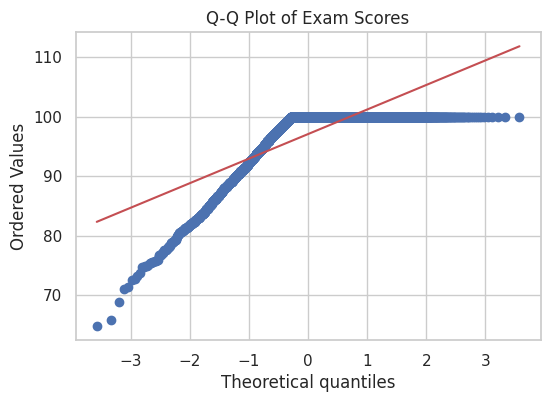

In [4]:
plt.figure(figsize=(6, 4))
stats.probplot(scores, dist="norm", plot=plt)
plt.title("Q-Q Plot of Exam Scores")
plt.show()


## 🟩 Part II — Mann–Whitney U Test (Two-Sample)

The Mann–Whitney U test is a non-parametric alternative to
the two-sample t-test.

$$
H_0: P(X > Y) = 0.5
$$

It tests whether two samples come from the same distribution.


### 🟦 Data Preparation

In [5]:
group_m = df[df.gender == "M"]["score"].values
group_f = df[df.gender == "F"]["score"].values


### 🟦 Mann–Whitney U Test

In [6]:
u_stat, p_mw = stats.mannwhitneyu(
    group_m,
    group_f,
    alternative="two-sided"
)

u_stat, p_mw


(np.float64(1870375.5), np.float64(5.3286237287061356e-05))

### 🟦 Interpretation

- A small p-value indicates a shift between distributions
- The test does not assume normality
- Results should be compared with parametric tests

Consistency strengthens conclusions.


## 🟩 Part III — Kruskal–Wallis Test (ANOVA Alternative)

### 🟦 Kruskal–Wallis Test

The Kruskal–Wallis test is the non-parametric alternative
to one-way ANOVA.

$$
H_0: \text{All group distributions are identical}
$$

It operates on ranked data.


In [7]:
stats.kruskal(
    df[df.teaching_method == "A"]["score"],
    df[df.teaching_method == "B"]["score"],
    df[df.teaching_method == "C"]["score"]
)


KruskalResult(statistic=np.float64(182.11351060894012), pvalue=np.float64(2.848089490527301e-40))

#### 🟦 Kruskal–Wallis Interpretation

- A significant result indicates at least one group differs
- The test does not specify which groups differ
- Post-hoc testing is required


## 🟩 Part IV — Post-hoc Tests for Non-Parametric ANOVA

### Post-hoc Testing

After a significant Kruskal–Wallis test, we must identify
which groups differ.

Pairwise Mann–Whitney tests with correction
control the Type I error rate.

### 🟦 Pairwise Mann–Whitney with Bonferroni

In [8]:
from itertools import combinations

groups = {
    "A": df[df.teaching_method == "A"]["score"],
    "B": df[df.teaching_method == "B"]["score"],
    "C": df[df.teaching_method == "C"]["score"]
}

results = []

for (g1, g2) in combinations(groups.keys(), 2):
    stat, p = stats.mannwhitneyu(
        groups[g1],
        groups[g2],
        alternative="two-sided"
    )
    results.append((g1, g2, p * 3))  # Bonferroni correction

results


[('A', 'B', np.float64(4.319376455132774e-11)),
 ('A', 'C', np.float64(1.0806950345761376e-10)),
 ('B', 'C', np.float64(1.3447023670818149e-40))]

### Post-hoc Interpretation

- Adjusted p-values control false positives
- Consistency with ANOVA results increases confidence
- Effect size should still be reported where possible


## 🟩 Part V — Parametric vs Non-Parametric Summary


| Scenario | Parametric | Non-Parametric |
|--------|-----------|----------------|
| Two groups | t-test | Mann–Whitney U |
| >2 groups | ANOVA | Kruskal–Wallis |
| Assumptions | Normality, variance | Minimal |
| Interpretation | Mean difference | Distribution shift |


## Summary

This notebook demonstrated:

- Why and when parametric assumptions fail
- How to test normality and inspect distributions
- Non-parametric alternatives for two-sample and multi-group comparisons
- Robust post-hoc testing strategies

Non-parametric tests complement parametric methods and
strengthen analytical conclusions.
